In [35]:
# Lead Scoring and Prioritization System
# This creates a comprehensive scoring system

print("="*70)
print("LEAD SCORING SYSTEM")
print("="*70)

LEAD SCORING SYSTEM


In [36]:
# Imports Libraries

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


In [37]:
# Load Models and Preprosessing Objects

print("\n Loading Models and Preprocessing Objects")
print("-"*70)

# Load all saved objects from notebook 02
model = joblib.load('../models/best_lead_scoring_model.pkl')
scaler = joblib.load('../models/scaler.pkl')
label_encoders = joblib.load('../models/label_encoders.pkl')
feature_cols = joblib.load('../models/feature_columns.pkl')

# Detect Model Type
model_name = type(model).__name__
print(" Loaded: best_lead_scoring_model.pkl")
print(" Loaded: scaler.pkl")
print(" Loaded: label_encoders.pkl")
print(" Loaded: feature_columns.pkl")



 Loading Models and Preprocessing Objects
----------------------------------------------------------------------
 Loaded: best_lead_scoring_model.pkl
 Loaded: scaler.pkl
 Loaded: label_encoders.pkl
 Loaded: feature_columns.pkl


In [38]:
# Load and Prepare data

print("\n" + "="*70)
print("Loading and Preparing Data")
print("-"*70)

df = pd.read_csv('../data/cleaned_sales_leads_dataset.csv')
print(f"Loaded {len(df)} leads")

# Keep lead_id for final report
lead_ids = df['lead_id'].copy()



Loading and Preparing Data
----------------------------------------------------------------------
Loaded 1000 leads


In [39]:
# Apply Feature Engineering

print("\n" + "="*70)
print("Applying Feature Engineering")
print("-"*70)

df_processed = df.copy()

# Apply SAME feature engineering as in notebook 02
df_processed['engagement_demo'] = df_processed['engagement_score'] * df_processed['demo_requested'].map({'Yes': 1, 'No': 0})
df_processed['budget_revenue_ratio'] = df_processed['budget_indicated_lkr'] / (df_processed['annual_revenue_lkr'] + 1)
df_processed['total_engagement'] = df_processed['website_visits'] + (df_processed['email_opens'] * 2)

contact_scores = {'Employee': 30, 'Manager': 60, 'C-Level': 100}
df_processed['contact_quality'] = df_processed['contact_level'].map(contact_scores)

df_processed['demo_flag'] = df_processed['demo_requested'].map({'Yes': 1, 'No': 0})
df_processed['competitor_flag'] = df_processed['competitor_using'].map({'Yes': 1, 'No': 0})

print(" Feature engineering applied")


Applying Feature Engineering
----------------------------------------------------------------------
 Feature engineering applied


In [40]:
# Encode Categorical Variables

print("\n" + "="*70)
print(" Encoding Categorical Variables")
print("-"*70)

categorical_cols = ['company_size', 'industry', 'location', 'contact_level', 'referral_source']

for col in categorical_cols:
    le = label_encoders[col]
    df_processed[col + '_encoded'] = le.transform(df_processed[col])
    print(f"Encoded: {col}")



 Encoding Categorical Variables
----------------------------------------------------------------------
Encoded: company_size
Encoded: industry
Encoded: location
Encoded: contact_level
Encoded: referral_source


In [41]:
# Prepare Features and Scale

print("\n" + "="*70)
print("Preparing Features for Prediction")
print("-"*70)

# Select same features as training
X = df_processed[feature_cols]
print(f"Selected {len(feature_cols)} features")

# Scale features using saved scaler
X_scaled = scaler.transform(X)
print("Features scaled")


Preparing Features for Prediction
----------------------------------------------------------------------
Selected 17 features
Features scaled


In [42]:
#Generate Model Predictions

print("\n" + "="*70)
print("Generating Model Predictions")
print("-"*70)

# Get prediction probabilities
model_probabilities = model.predict_proba(X_scaled)[:, 1]
df_processed['model_probability'] = model_probabilities * 100

print(f"Model predictions generated")
print(f"   Average probability: {df_processed['model_probability'].mean():.2f}%")
print(f"   Min probability: {df_processed['model_probability'].min():.2f}%")
print(f"   Max probability: {df_processed['model_probability'].max():.2f}%")


Generating Model Predictions
----------------------------------------------------------------------
Model predictions generated
   Average probability: 70.77%
   Min probability: 12.93%
   Max probability: 99.24%


In [43]:
# Calculate Composite Lead Scores

print("\n" + "="*70)
print("Calculating Composite Lead Scores")
print("-"*70)

def calculate_composite_score(row):
    """
    Calculate composite lead score using weighted formula:
    
    Composite Score = 
        Model Prediction (50%) +
        Engagement Score (25%) +
        Budget/Revenue Ratio (15%) +
        Contact Quality (10%)
    """
    model_score = row['model_probability']
    engagement = row['engagement_score']
    budget_ratio = min(row['budget_revenue_ratio'] * 1000, 100)
    contact_quality = row['contact_quality']
    
    composite = (
        model_score * 0.50 +
        engagement * 0.25 +
        budget_ratio * 0.15 +
        contact_quality * 0.10
    )
    
    return round(composite, 2)

df_processed['lead_score'] = df_processed.apply(calculate_composite_score, axis=1)

print(" Composite scores calculated")
print(f"\nScore Statistics:")
print(f"   Mean: {df_processed['lead_score'].mean():.2f}")
print(f"   Median: {df_processed['lead_score'].median():.2f}")
print(f"   Std Dev: {df_processed['lead_score'].std():.2f}")
print(f"   Min: {df_processed['lead_score'].min():.2f}")
print(f"   Max: {df_processed['lead_score'].max():.2f}")


Calculating Composite Lead Scores
----------------------------------------------------------------------
 Composite scores calculated

Score Statistics:
   Mean: 66.38
   Median: 69.38
   Std Dev: 16.43
   Min: 19.53
   Max: 94.17


In [44]:
# Assign Priority Levels

print("\n" + "="*70)
print("Assigning Priority Levels")
print("-"*70)

def assign_priority_percentile(scores):
    """
    Assign priorities based on percentiles (like scripts):
    - HIGH: Top 20% (80th percentile and above)
    - MEDIUM: Middle 30% (50th to 80th percentile)
    - LOW: Bottom 50% (below 50th percentile)
    """
    high_threshold = np.percentile(scores, 80)
    medium_threshold = np.percentile(scores, 50)
    
    priorities = []
    for score in scores:
        if score >= high_threshold:
            priorities.append('HIGH')
        elif score >= medium_threshold:
            priorities.append('MEDIUM')
        else:
            priorities.append('LOW')
    
    return priorities, high_threshold, medium_threshold

priorities, high_threshold, medium_threshold = assign_priority_percentile(df_processed['lead_score'].values)
df_processed['priority'] = priorities

print(f"Priority levels assigned using percentiles")
print(f"   HIGH threshold: {high_threshold:.2f} (80th percentile)")
print(f"   MEDIUM threshold: {medium_threshold:.2f} (50th percentile)")

priority_counts = df_processed['priority'].value_counts()
print(f"\n📊 Priority Distribution:")
for priority in ['HIGH', 'MEDIUM', 'LOW']:
    count = priority_counts.get(priority, 0)
    pct = (count / len(df_processed)) * 100
    print(f"   {priority}: {count} ({pct:.1f}%)")


Assigning Priority Levels
----------------------------------------------------------------------
Priority levels assigned using percentiles
   HIGH threshold: 81.74 (80th percentile)
   MEDIUM threshold: 69.38 (50th percentile)

📊 Priority Distribution:
   HIGH: 200 (20.0%)
   MEDIUM: 301 (30.1%)
   LOW: 499 (49.9%)


In [45]:
#Assign Pipeline Stages


print("\n" + "="*70)
print("Assigning Sales Pipeline Stages")
print("-"*70)

def assign_pipeline_stage(row):
    """Assign leads to pipeline stages based on characteristics"""
    if row['converted'] == 1:
        return 'Converted'
    elif row['demo_requested'] == 'Yes':
        return 'Demo/Trial'
    elif row['email_opens'] > 10 or row['website_visits'] > 20:
        return 'Qualified'
    elif row['engagement_score'] > 50:
        return 'Engaged'
    else:
        return 'New'

df_processed['pipeline_stage'] = df_processed.apply(assign_pipeline_stage, axis=1)

stage_counts = df_processed['pipeline_stage'].value_counts()
print("Pipeline stages assigned")
print(f"\n Pipeline Distribution:")
for stage in ['New', 'Engaged', 'Qualified', 'Demo/Trial', 'Converted']:
    count = stage_counts.get(stage, 0)
    pct = (count / len(df_processed)) * 100
    print(f"   {stage}: {count} ({pct:.1f}%)")



Assigning Sales Pipeline Stages
----------------------------------------------------------------------
Pipeline stages assigned

 Pipeline Distribution:
   New: 47 (4.7%)
   Engaged: 11 (1.1%)
   Qualified: 93 (9.3%)
   Demo/Trial: 31 (3.1%)
   Converted: 818 (81.8%)


In [46]:
# Display Lead Priority Matrix
# ============================================
print("\n" + "="*70)
print("Lead Prioritization Matrix - Top 20 Leads")
print("-"*70)

top_leads = df_processed[['lead_id', 'company_size', 'industry', 'location',
                          'lead_score', 'priority', 'pipeline_stage', 'converted']].sort_values(
    'lead_score', ascending=False
).head(20)

print(top_leads.to_string(index=False))


Lead Prioritization Matrix - Top 20 Leads
----------------------------------------------------------------------
  lead_id company_size      industry   location  lead_score priority pipeline_stage  converted
LEAD_0628        Large    Healthcare     Matara       94.17     HIGH      Converted          1
LEAD_0389        Large     Education    Negombo       93.29     HIGH      Converted          1
LEAD_0139        Large Manufacturing Kurunegala       93.19     HIGH      Converted          1
LEAD_0064        Large   Agriculture      Galle       93.17     HIGH      Converted          1
LEAD_0023        Large        Retail     Matara       92.96     HIGH      Converted          1
LEAD_0498        Large       Finance    Colombo       92.67     HIGH      Converted          1
LEAD_0893        Large    Healthcare Kurunegala       92.56     HIGH      Converted          1
LEAD_0031        Large     Education     Matara       92.56     HIGH      Converted          1
LEAD_0640        Large       Fi


Creating Visualizations
----------------------------------------------------------------------


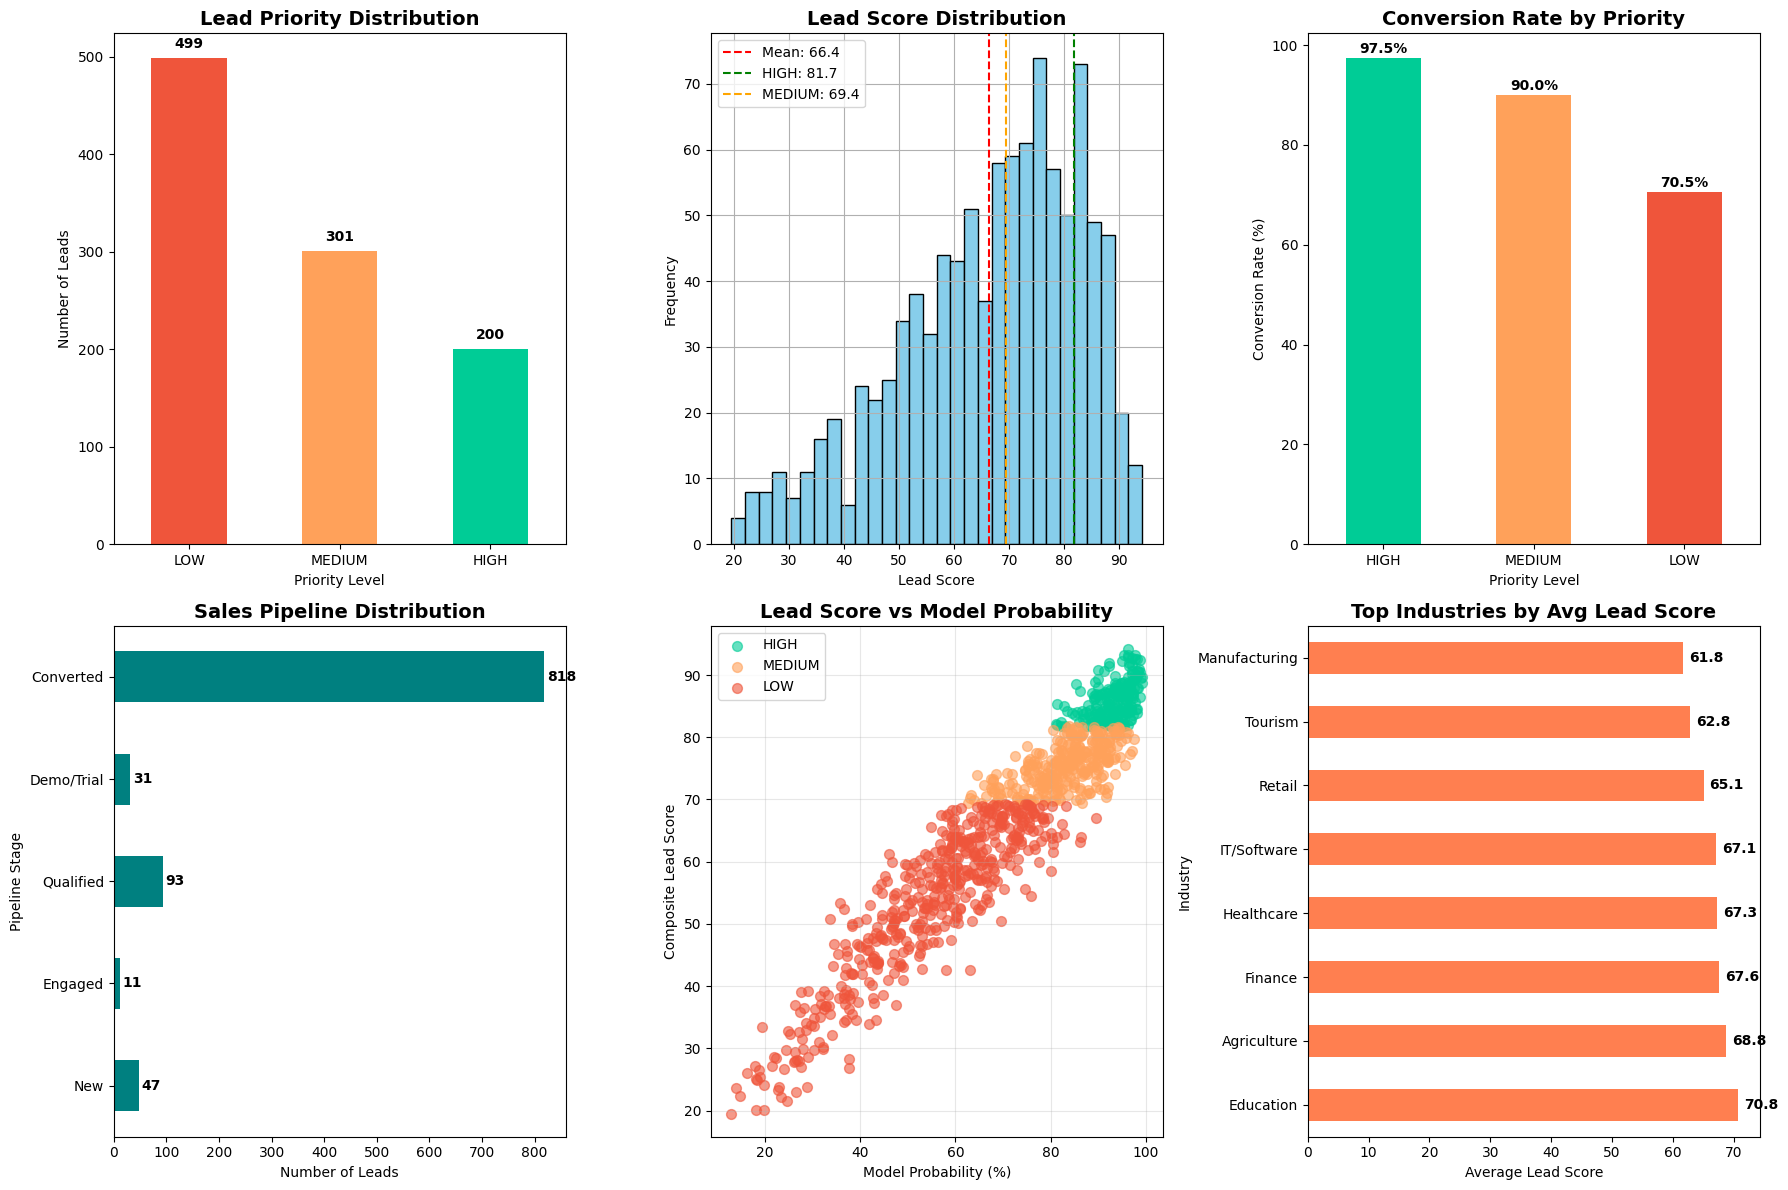

 Visualizations saved: reports/lead_scoring_analysis.png


In [47]:
# Visualization

print("\n" + "="*70)
print("Creating Visualizations")
print("-"*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Priority Distribution
ax1 = axes[0, 0]
colors = {'HIGH': '#00CC96', 'MEDIUM': '#FFA15A', 'LOW': '#EF553B'}
priority_counts.plot(kind='bar', ax=ax1, color=[colors[p] for p in priority_counts.index])
ax1.set_title('Lead Priority Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Priority Level')
ax1.set_ylabel('Number of Leads')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
for i, v in enumerate(priority_counts.values):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

# 2. Score Distribution
ax2 = axes[0, 1]
df_processed['lead_score'].hist(bins=30, ax=ax2, color='skyblue', edgecolor='black')
ax2.set_title('Lead Score Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Lead Score')
ax2.set_ylabel('Frequency')
ax2.axvline(df_processed['lead_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df_processed["lead_score"].mean():.1f}')
ax2.axvline(high_threshold, color='green', linestyle='--', 
            label=f'HIGH: {high_threshold:.1f}')
ax2.axvline(medium_threshold, color='orange', linestyle='--', 
            label=f'MEDIUM: {medium_threshold:.1f}')
ax2.legend()

# 3. Conversion by Priority
ax3 = axes[0, 2]
conv_by_priority = df_processed.groupby('priority')['converted'].mean() * 100
conv_by_priority = conv_by_priority.reindex(['HIGH', 'MEDIUM', 'LOW'])
conv_by_priority.plot(kind='bar', ax=ax3, color=[colors[p] for p in conv_by_priority.index])
ax3.set_title('Conversion Rate by Priority', fontsize=14, fontweight='bold')
ax3.set_xlabel('Priority Level')
ax3.set_ylabel('Conversion Rate (%)')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
for i, v in enumerate(conv_by_priority.values):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. Pipeline Stage Distribution
ax4 = axes[1, 0]
stage_order = ['New', 'Engaged', 'Qualified', 'Demo/Trial', 'Converted']
stage_counts_ordered = df_processed['pipeline_stage'].value_counts().reindex(stage_order, fill_value=0)
stage_counts_ordered.plot(kind='barh', ax=ax4, color='teal')
ax4.set_title('Sales Pipeline Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Leads')
ax4.set_ylabel('Pipeline Stage')
for i, v in enumerate(stage_counts_ordered.values):
    ax4.text(v + 5, i, str(v), va='center', fontweight='bold')

# 5. Score vs Model Probability
ax5 = axes[1, 1]
for priority in ['HIGH', 'MEDIUM', 'LOW']:
    data = df_processed[df_processed['priority'] == priority]
    ax5.scatter(data['model_probability'], data['lead_score'], 
                label=priority, alpha=0.6, s=50, color=colors[priority])
ax5.set_title('Lead Score vs Model Probability', fontsize=14, fontweight='bold')
ax5.set_xlabel('Model Probability (%)')
ax5.set_ylabel('Composite Lead Score')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Top Industries by Score
ax6 = axes[1, 2]
industry_avg = df_processed.groupby('industry')['lead_score'].mean().sort_values(ascending=False).head(8)
industry_avg.plot(kind='barh', ax=ax6, color='coral')
ax6.set_title('Top Industries by Avg Lead Score', fontsize=14, fontweight='bold')
ax6.set_xlabel('Average Lead Score')
ax6.set_ylabel('Industry')
for i, v in enumerate(industry_avg.values):
    ax6.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/lead_scoring_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualizations saved: reports/lead_scoring_analysis.png")




Feature Analysis
----------------------------------------------------------------------

 Top 10 Most Influential Features (Logistic Regression):
             feature  coefficient
     engagement_demo     1.328432
           demo_flag    -0.971598
    engagement_score     0.918459
company_size_encoded    -0.806536
  annual_revenue_lkr     0.356109
budget_indicated_lkr    -0.327985
    total_engagement    -0.281511
      website_visits    -0.255872
budget_revenue_ratio    -0.255373
    location_encoded     0.187518

Note: Positive = increases conversion probability, Negative = decreases

 Saved: reports/feature_coefficients.csv


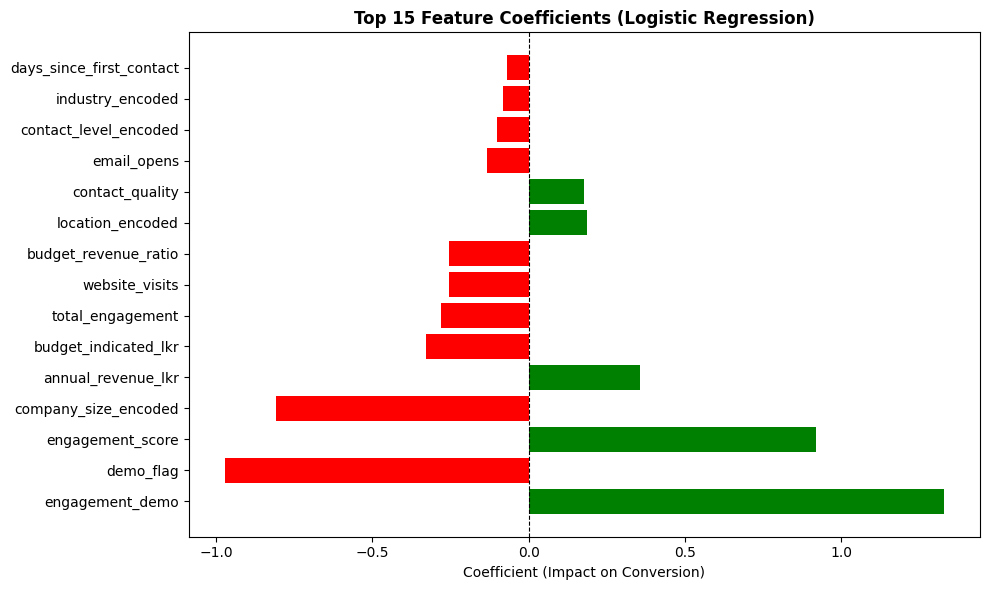

 Saved: reports/feature_coefficients_plot.png


In [48]:
# Feature Importance

print("\n" + "="*70)
print("Feature Analysis")
print("-"*70)

if 'DecisionTree' in model_name:
    # For Decision Tree - show feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n Top 10 Most Important Features (Decision Tree):")
    print(feature_importance.head(10).to_string(index=False))
    
    # Save feature importance
    feature_importance.to_csv('../reports/feature_importance.csv', index=False)
    print("\n Saved: reports/feature_importance.csv")
    
    # Visualize feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    top_features = feature_importance.head(15)
    ax.barh(top_features['feature'], top_features['importance'], color='skyblue')
    ax.set_xlabel('Importance')
    ax.set_title('Top 15 Feature Importances (Decision Tree)', fontweight='bold')
    plt.tight_layout()
    plt.savefig('../reports/feature_importance_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: reports/feature_importance_plot.png")

elif 'LogisticRegression' in model_name:
    # For Logistic Regression - show coefficients
    feature_coef = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\n Top 10 Most Influential Features (Logistic Regression):")
    print(feature_coef.head(10)[['feature', 'coefficient']].to_string(index=False))
    print("\nNote: Positive = increases conversion probability, Negative = decreases")
    
    # Save feature coefficients
    feature_coef.to_csv('../reports/feature_coefficients.csv', index=False)
    print("\n Saved: reports/feature_coefficients.csv")
    
    # Visualize coefficients
    fig, ax = plt.subplots(figsize=(10, 6))
    top_features = feature_coef.head(15)
    colors_coef = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
    ax.barh(top_features['feature'], top_features['coefficient'], color=colors_coef)
    ax.set_xlabel('Coefficient (Impact on Conversion)')
    ax.set_title('Top 15 Feature Coefficients (Logistic Regression)', fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('../reports/feature_coefficients_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: reports/feature_coefficients_plot.png")

In [49]:
# Save Scored Leads

print("\n" + "="*70)
print("Saving Scored Leads")
print("-"*70)

# Save complete scored dataset
df_processed.to_csv('../data/scored_leads.csv', index=False)
print("Saved: data/scored_leads.csv")

# Save prioritization report
priority_report = df_processed[['lead_id', 'company_size', 'industry', 'location',
                                 'engagement_score', 'contact_level', 'demo_requested',
                                 'model_probability', 'lead_score', 'priority',
                                 'pipeline_stage', 'converted']].sort_values('lead_score', ascending=False)

priority_report.to_csv('../reports/lead_prioritization_report.csv', index=False)
print("Saved: reports/lead_prioritization_report.csv")



Saving Scored Leads
----------------------------------------------------------------------
Saved: data/scored_leads.csv
Saved: reports/lead_prioritization_report.csv


In [50]:
# Summary Statics

print("\n" + "="*70)
print("Summary Statistics")
print("-"*70)

print(f"\nOverall Metrics:")
print(f"   Model Used: {model_name}")
print(f"   Total Leads: {len(df_processed):,}")
print(f"   Average Lead Score: {df_processed['lead_score'].mean():.2f}")
print(f"   Conversion Rate: {df_processed['converted'].mean()*100:.2f}%")

print(f"\n Priority Breakdown:")
for priority in ['HIGH', 'MEDIUM', 'LOW']:
    subset = df_processed[df_processed['priority'] == priority]
    count = len(subset)
    pct = (count / len(df_processed)) * 100
    avg_score = subset['lead_score'].mean()
    conv_rate = subset['converted'].mean() * 100
    print(f"\n   {priority} Priority:")
    print(f"      Count: {count} ({pct:.1f}%)")
    print(f"      Avg Score: {avg_score:.2f}")
    print(f"      Conversion Rate: {conv_rate:.2f}%")

print("\n" + "="*70)
print("LEAD SCORING COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"\n Files Created:")
print(f"   • data/scored_leads.csv")
print(f"   • reports/lead_prioritization_report.csv")
print(f"   • reports/lead_scoring_analysis.png")
if 'DecisionTree' in model_name:
    print(f"   • reports/feature_importance.csv")
    print(f"   • reports/feature_importance_plot.png")
elif 'LogisticRegression' in model_name:
    print(f"   • reports/feature_coefficients.csv")
    print(f"   • reports/feature_coefficients_plot.png")

print(f"\n Next Steps:")
print(f"   1. Run notebook 04 for funnel tracking and reports")
print(f"   2. Launch dashboard: streamlit run dashboard.py")
print(f"   3. All data is ready for analysis!")



Summary Statistics
----------------------------------------------------------------------

Overall Metrics:
   Model Used: LogisticRegression
   Total Leads: 1,000
   Average Lead Score: 66.38
   Conversion Rate: 81.80%

 Priority Breakdown:

   HIGH Priority:
      Count: 200 (20.0%)
      Avg Score: 86.00
      Conversion Rate: 97.50%

   MEDIUM Priority:
      Count: 301 (30.1%)
      Avg Score: 75.40
      Conversion Rate: 90.03%

   LOW Priority:
      Count: 499 (49.9%)
      Avg Score: 53.08
      Conversion Rate: 70.54%

LEAD SCORING COMPLETED SUCCESSFULLY!

 Files Created:
   • data/scored_leads.csv
   • reports/lead_prioritization_report.csv
   • reports/lead_scoring_analysis.png
   • reports/feature_coefficients.csv
   • reports/feature_coefficients_plot.png

 Next Steps:
   1. Run notebook 04 for funnel tracking and reports
   2. Launch dashboard: streamlit run dashboard.py
   3. All data is ready for analysis!
